In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import json
import matplotlib.pyplot as plt
import mne
import numpy as np
from deepexplain.tf.v2_x import DeepExplain
from src.models.utils import load_dataset
from src.visualizations.utils import plot_attributions, plot_attributions_topomap
import tensorflow.compat.v1.keras.backend as K

import warnings
warnings.filterwarnings("ignore")

# open config file
f = open("..//config//config.json",)
config = json.load(f)

Using tf version = 2.6.0
Using tf version = 2.6.0


In [2]:
# load test data
config["dataset"]["save_path"] = "..//data//"
_, _, _, _, X_test, y_test = load_dataset(config)

In [3]:
# load model
model_path = "..//models//" + config["train"]["experiment_desc"] + "-best.h5"
model = tf.keras.models.load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# attributions
# DeepExplain https://github.com/marcoancona/DeepExplain

with DeepExplain(session = K.get_session()) as de:
	# the level for which to find attributions
	input_tensor   = model.layers[0].input # input layer
	fModel         = tf.keras.models.Model(inputs = input_tensor, outputs = model.layers[-2].output)  
	target_tensor  = fModel(input_tensor)#input_tensor)    # change target if you want attributions for other intermediate layers and not the input

	# attributions
	deeplift_attributions = de.explain('deeplift', target_tensor * y_test, input_tensor, X_test)
	elrp_attributions = de.explain('elrp', target_tensor * y_test, input_tensor, X_test)
	saliency_attributions = de.explain('saliency', target_tensor * y_test, input_tensor, X_test)
	intgrad_attributions = de.explain('intgrad', target_tensor * y_test, input_tensor, X_test)

100%|██████████| 100/100 [05:03<00:00,  3.04s/it]


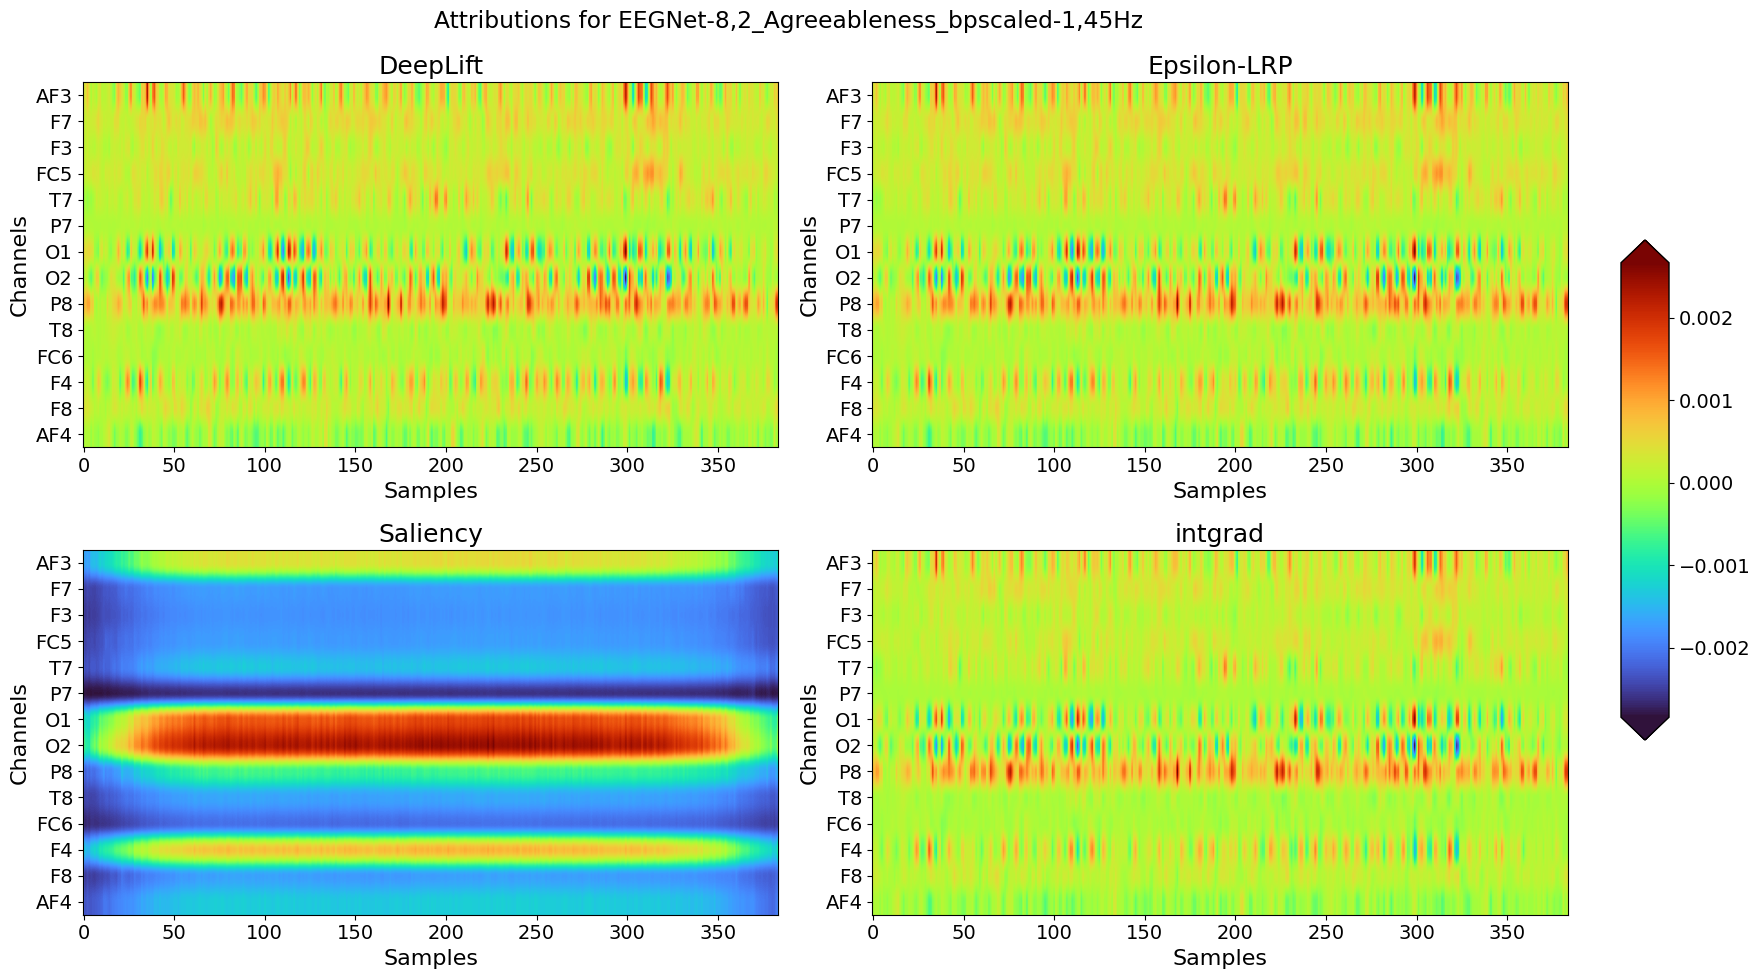

In [18]:
# Plot image results of the 4 attribution methods
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# plot style
plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=16) #fontsize of the legend

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,10), tight_layout=True) 
title = 'Attributions for ' + config["train"]["experiment_desc"] 
plt.suptitle(title)

im = ax1.imshow(np.mean(deeplift_attributions, axis=0).squeeze(), aspect='auto', cmap ='turbo')
ax1.set_title('DeepLift')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Channels')
ax1.set_yticks(np.arange(0,14,1))
ax1.set_yticklabels(channels)

im = ax2.imshow(np.mean(elrp_attributions, axis=0).squeeze(), aspect='auto', cmap ='turbo')
ax2.set_title('Epsilon-LRP')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Channels')
ax2.set_yticks(np.arange(0,14,1))
ax2.set_yticklabels(channels)

im = ax3.imshow(np.mean(saliency_attributions, axis=0).squeeze(), aspect='auto', cmap ='turbo')
ax3.set_title('Saliency')
ax3.set_xlabel('Samples')
ax3.set_ylabel('Channels')
ax3.set_yticks(np.arange(0,14,1))
ax3.set_yticklabels(channels)

im = ax4.imshow(np.mean(intgrad_attributions, axis=0).squeeze(), aspect='auto', cmap ='turbo')
ax4.set_title('intgrad')
ax4.set_xlabel('Samples')
ax4.set_ylabel('Channels')
ax4.set_yticks(np.arange(0,14,1))
ax4.set_yticklabels(channels)

cb_ax = fig.add_axes([1.02, 0.25, 0.03, 0.5])
cbar = fig.colorbar(im, cax=cb_ax, pad=0.8, aspect=7, shrink=0.5,extend='both')
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
cbar.outline.set_visible(True)

In [4]:
# or load attributions
deeplift_attributions = np.load("..//models/attributions//" + config["train"]["experiment_desc"] + "_attributions.npy")

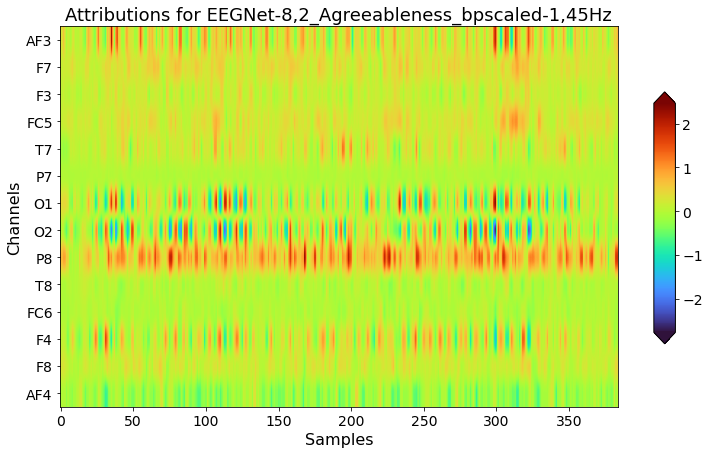

In [7]:
# plot image
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

fig = plot_attributions(deeplift_attributions, config, channels, scalings = 1e3)

fig.savefig('..//reports/attributions//attributions_example_image.png', dpi=300, bbox_inches='tight')

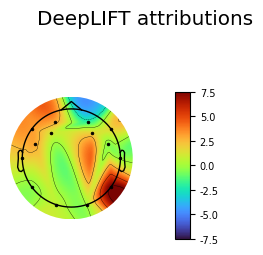

In [8]:
# plot topomap
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

fig = plot_attributions_topomap(deeplift_attributions, config, channels, scalings = 1e1, title = "DeepLIFT attributions")

fig.savefig('..//reports/attributions//attributions_example_topomap.png', dpi=300, bbox_inches='tight')